# Sprint17 Faster R-CNN & YOLOv3

# 【問題1】学習と推定
READMEを参考に上記実装を動かしてください。

https://github.com/duckrabbits/ObjectDetection/tree/master

# 【問題2】コードリーディング
上記実装のコードリーディングを行ってください。


まず、Faster R-CNN[1]において重要だと考えた部分を列挙してください。そして、それに対応するコードを見つけてください。

In [10]:
from __future__ import division

import os
import sys
import time
import argparse
from datetime import datetime

import numpy as np

import pickle

from model import faster_rcnn

from model import config, data_generators

from model.parser import get_data
import model.roi_helpers as roi_helpers

from keras import backend as K
from keras.utils import generic_utils

sys.setrecursionlimit(10000)

parser = argparse.ArgumentParser(formatter_class=argparse.RawTextHelpFormatter, description='Object Detection')
parser.add_argument("-p", "--path", default=None, help="path to annotation file")
parser.add_argument("--save_dir", default="./save", help="path to save directory")
parser.add_argument('--n_epochs', default=10, type=int, metavar='N',
                    help='number of epochs')
parser.add_argument('--n_iters', default=10, type=int, metavar='N',
                    help='number of iterations')
parser.add_argument('--horizontal_flips', action='store_true',
                    help='augument with horizontal flips (Default:False)')
parser.add_argument('--vertical_flips', action='store_true',
                    help='augument with horizontal flips (Default:False)')
parser.add_argument('--rot_90', action='store_true',
                    help='augument with 90 degree rotations (Default:False)')

def main():
    args = parser.parse_args()
    time_stamp = "{0:%Y%m%d-%H%M%S}".format(datetime.now())
    save_name = os.path.join(args.save_dir, "train_{}".format(time_stamp))

    if not(os.path.isdir(args.save_dir)):
        os.makedirs(args.save_dir)
    if args.path == None:
        raise OSError("path to annotation file must be required.")
    C = config.Config()
    C.config_filename = save_name + "_config.pickle"
    C.model_path = save_name + "_model.hdf5"
    C.use_horizontal_flips = bool(args.horizontal_flips)
    C.use_vertical_flips = bool(args.vertical_flips)
    C.rot_90 = bool(args.rot_90)
    all_imgs, classes_count, class_mapping = get_data(args.path)
    C.class_mapping = class_mapping

    with open(C.config_filename, 'wb') as config_f:
        pickle.dump(C,config_f)
        print("-------------------------------")
        print('path to config file : {}'.format(C.config_filename))
        print("-------------------------------")

    train_imgs = [s for s in all_imgs if s['imageset'] == 'trainval']
    val_imgs = [s for s in all_imgs if s['imageset'] == 'test']

    data_gen_train = data_generators.get_anchor_gt(train_imgs, classes_count, C, K.image_data_format(), mode='train')
    data_gen_val = data_generators.get_anchor_gt(val_imgs, classes_count, C, K.image_data_format(), mode='val')

    model_rpn, model_classifier, model_all = faster_rcnn.get_model(C, classes_count)

    losses = np.zeros((args.n_iters, 5))
    rpn_accuracy_rpn_monitor, rpn_accuracy_for_epoch = [], []

    best_loss = np.Inf

    with open('out.csv', 'w') as f:
        f.write('Accuracy,RPN classifier,RPN regression,Detector classifier,Detector regression,Total')
        f.write('\t')

    iter_num = 0

    t0 = start_time = time.time()
    print(model_all.summary())
    try:
        for epoch_num in range(args.n_epochs):
            progbar = generic_utils.Progbar(args.n_iters)
            print('Epoch {}/{}'.format(epoch_num + 1, args.n_epochs))

            while True:
                try:
                    #RPN動作開始＃
                    if len(rpn_accuracy_rpn_monitor) == args.n_iters and C.verbose:
                        mean_overlapping_bboxes = float(sum(rpn_accuracy_rpn_monitor))/len(rpn_accuracy_rpn_monitor)
                        rpn_accuracy_rpn_monitor = []
                        print('Average number of overlapping bounding boxes from RPN = {} for {} previous iterations'.format(mean_overlapping_bboxes, args.n_iters))
                        if mean_overlapping_bboxes == 0:
                            print('RPN is not producing bounding boxes that overlap the ground truth boxes. Check RPN settings or keep training.')
                    X, Y, img_data = next(data_gen_train)
                    loss_rpn = model_rpn.train_on_batch(X, Y)
                    P_rpn = model_rpn.predict_on_batch(X)
                    R = roi_helpers.rpn_to_roi(P_rpn[0], P_rpn[1], C, K.image_data_format(), use_regr=True, overlap_thresh=0.7, max_boxes=300)

                    # note: calc_iou converts from (x1,y1,x2,y2) to (x,y,w,h) format
                    X2, Y1, Y2 = roi_helpers.calc_iou(R, img_data, C, class_mapping)

                    neg_samples = np.where(Y1[0, :, -1] == 1)
                    pos_samples = np.where(Y1[0, :, -1] == 0)
                    if len(neg_samples) > 0:
                        neg_samples = neg_samples[0]
                    else:
                        neg_samples = []

                    if len(pos_samples) > 0:
                        pos_samples = pos_samples[0]
                    else:
                        pos_samples = []

                    rpn_accuracy_rpn_monitor.append(len(pos_samples))
                    rpn_accuracy_for_epoch.append((len(pos_samples)))
                    if len(pos_samples) < C.num_rois//2:
                        selected_pos_samples = pos_samples.tolist()
                    else:
                        selected_pos_samples = np.random.choice(pos_samples, C.num_rois//2, replace=False).tolist()
                    try:
                        selected_neg_samples = np.random.choice(neg_samples, C.num_rois - len(selected_pos_samples), replace=False).tolist()
                    except:
                        selected_neg_samples = np.random.choice(neg_samples, C.num_rois - len(selected_pos_samples), replace=True).tolist()

                    sel_samples = selected_pos_samples + selected_neg_samples

                    loss_class = model_classifier.train_on_batch([X, X2[:, sel_samples, :]], [Y1[:, sel_samples, :], Y2[:, sel_samples, :]])
                    #RPN動作終了＃

                    if iter_num == args.n_iters:
                        loss_rpn_cls = np.mean(losses[:, 0])
                        loss_rpn_regr = np.mean(losses[:, 1])
                        loss_class_cls = np.mean(losses[:, 2])
                        loss_class_regr = np.mean(losses[:, 3])
                        class_acc = np.mean(losses[:, 4])

                        mean_overlapping_bboxes = float(sum(rpn_accuracy_for_epoch)) / len(rpn_accuracy_for_epoch)
                        rpn_accuracy_for_epoch = []

                        if C.verbose:
                            print('Mean number of bounding boxes from RPN overlapping ground truth boxes: {}'.format(mean_overlapping_bboxes))
                            print('Classifier accuracy for bounding boxes from RPN: {}'.format(class_acc))
                            print('Loss RPN classifier: {}'.format(loss_rpn_cls))
                            print('Loss RPN regression: {}'.format(loss_rpn_regr))
                            print('Loss Detector classifier: {}'.format(loss_class_cls))
                            print('Loss Detector regression: {}'.format(loss_class_regr))
                            print('Elapsed time: {}[s]'.format(time.time() - start_time))

                        target_text_file = open('out.csv', 'a')
                        target_text_file.write('{},{},{},{},{},{}'.format(class_acc, loss_rpn_cls,
                                                loss_rpn_regr, loss_class_cls, loss_class_regr,
                                                loss_rpn_cls + loss_rpn_regr + loss_class_cls + loss_class_regr))
                        target_text_file.write('\t')

                        curr_loss = loss_rpn_cls + loss_rpn_regr + loss_class_cls + loss_class_regr
                        iter_num = 0
                        start_time = time.time()

                        if curr_loss < best_loss:
                            if C.verbose:
                                print('Total loss decreased from {} to {}, saving weights'.format(best_loss,curr_loss))
                            best_loss = curr_loss
                            model_all.save_weights(C.model_path)
                        break

                    losses[iter_num, 0] = loss_rpn[1]
                    losses[iter_num, 1] = loss_rpn[2]
                    losses[iter_num, 2] = loss_class[1]
                    losses[iter_num, 3] = loss_class[2]
                    losses[iter_num, 4] = loss_class[3]
                    iter_num += 1

                    progbar.update(iter_num, [('rpn_cls', np.mean(losses[:iter_num, 0])), ('rpn_regr', np.mean(losses[:iter_num, 1])),
                                              ('detector_cls', np.mean(losses[:iter_num, 2])), ('detector_regr', np.mean(losses[:iter_num, 3]))])

                except Exception as e:
                    print('Exception: {}'.format(e))
                    continue

    except KeyboardInterrupt:
        t1 = time.time()
        print('\nIt took {:.2f}s'.format(t1-t0))
        sys.exit('Keyboard Interrupt')

    print("training is done")
    print("-------------------------------")
    print('path to config file : {}'.format(C.config_filename))
    print("-------------------------------")

if __name__ == '__main__':
    main()

SyntaxError: ignored

# 【問題3】学習済みの重みによる推定
学習済みの重みを使い推定を行う方法がREADME.mdのQuick Startの項に記載されています。


まずはこの通りにして各自何かしらの画像や動画に対して検出を行ってください。


出力結果を課題の一部として提出してください。

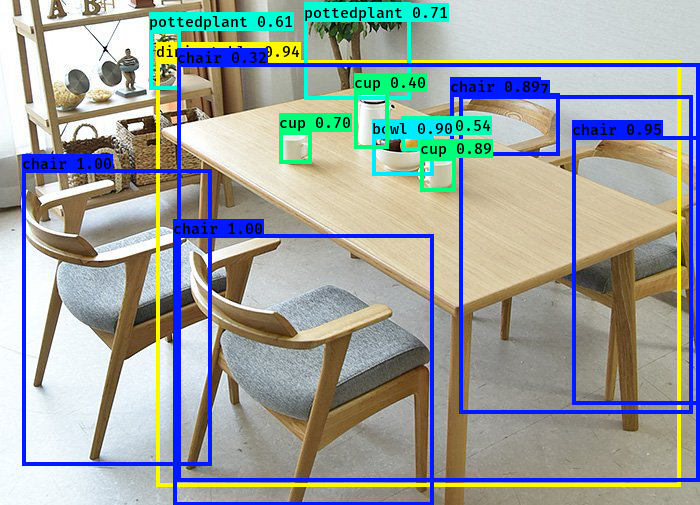

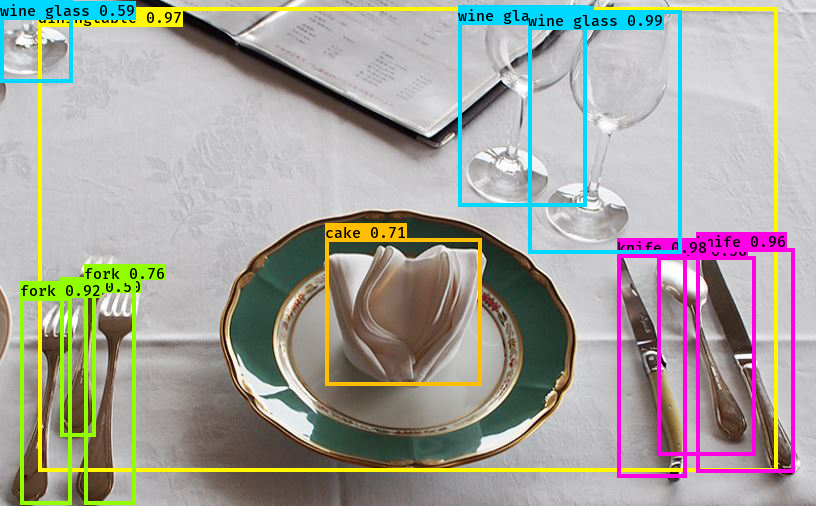

# 【問題4】学習のためのファイルを作成
新しいデータ（シンプソンズデータセット）を学習します。README.mdのTrainingの項を読み、シンプソンズデータセットを学習するために必要なファイルを作成してください。


アノテーションファイルの形式が問題1の実装とは異なるため変換する必要があります。

In [15]:
import pandas as pd
annotation_df = pd.read_csv('/content/sample_data/annotation.txt',header=None)
n_sample, n_col = annotation_df.shape
print(n_sample,n_col)
annotation_df.head()

6752 6


,0,1,2,3,4,5
0,./characters/abraham_grampa_simpson/pic_0000.jpg,57,72,52,72,abraham_grampa_simpson
1,./characters/abraham_grampa_simpson/pic_0001.jpg,80,31,337,354,abraham_grampa_simpson
2,./characters/abraham_grampa_simpson/pic_0002.jpg,128,48,285,407,abraham_grampa_simpson
3,./characters/abraham_grampa_simpson/pic_0003.jpg,72,126,158,275,abraham_grampa_simpson
4,./characters/abraham_grampa_simpson/pic_0004.jpg,123,61,294,416,abraham_grampa_simpson


In [16]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
annotation_df.iloc[:,5] = le.fit_transform(annotation_df.iloc[:,5])
annotation_df.tail()

,0,1,2,3,4,5
6747,./characters/sideshow_bob/pic_0721.jpg,32,89,225,323,17
6748,./characters/sideshow_bob/pic_0779.jpg,110,2,503,392,17
6749,./characters/sideshow_bob/pic_0609.jpg,198,3,525,346,17
6750,./characters/sideshow_bob/pic_0427.jpg,103,75,240,253,17
6751,./characters/sideshow_bob/pic_0839.jpg,43,1,125,144,17


In [35]:
path = '/content/sample_data/annotation.txt'
out_path = 'train.txt'

with open(path) as f:
  for i in range(n_sample):
    lines = f.readline()
    split_line = lines.split(',') 
    image_path = split_line[0]
    # split_line[0] = './' + image_path 
    split_line[-1] = str(annotation_df.iloc[i,5]) + '\n' 

    with open(out_path, mode='a') as out_f:
      join_line = ','.join(split_line)  
      join_line = join_line.replace('.jpg,','.jpg ')  
      out_f.write(join_line)

In [36]:
pd.read_csv('/content/train.txt',header=None)

,0,1,2,3,4
0,./characters/abraham_grampa_simpson/pic_0000.j...,72,52,72,0
1,./characters/abraham_grampa_simpson/pic_0001.j...,31,337,354,0
2,./characters/abraham_grampa_simpson/pic_0002.j...,48,285,407,0
3,./characters/abraham_grampa_simpson/pic_0003.j...,126,158,275,0
4,./characters/abraham_grampa_simpson/pic_0004.j...,61,294,416,0
...,...,...,...,...,...
6747,./characters/sideshow_bob/pic_0721.jpg 32,89,225,323,17
6748,./characters/sideshow_bob/pic_0779.jpg 110,2,503,392,17
6749,./characters/sideshow_bob/pic_0609.jpg 198,3,525,346,17
6750,./characters/sideshow_bob/pic_0427.jpg 103,75,240,253,17


# 【問題5】学習が行えることの確認
問題4で作成したファイルを使用して学習してください。実行環境で学習に時間がかかる場合は、学習が行えることを確認するのみで終えて構いません。

In [4]:
#学習完了済み

*   R-CNN (Regions with Convolutional Neural Networks) では、四角形の領域提案を畳み込みニューラル ネットワークの特徴と組み合わせます。
*   領域提案をトリミングしてサイズ変更する R-CNN 検出器とは異なり、Fast R-CNN 検出器ではイメージ全体を処理します
*   RegionProposal=領域提案
*   F-RCNNでは画像認識を行う時には毎回CNNを走らせる必要はなく、RegionProposalの抽出した特徴領域を切り出し、全結合層に与えるだけでよい。
従来のR-CNNが画像認識毎にCNN層も走らせていたのに比べると大幅な高速化を達成できる。

*   リスト項目
*   リスト項目





# 物体検知とバウンディングボックス
クラスと一緒に物体の位置を予測することを物体検出(object detection)と呼びます。
画像から物体のクラスを予測する代わりに、クラスとその物体を含む矩形（バウンディングボックスという）を予測する必要があります。

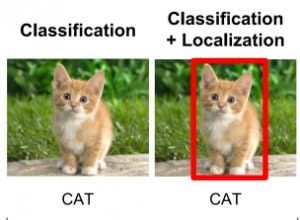

# Selective Search
オリジナルのRCNNで使われたRegion Proposalの抽出方法。一言で言えば「画像内の似ているピクセルをまとめるための教師なしアルゴリズム」という感じ。ただしめちゃくちゃアドホックなモデルで計算コストが重いので、FastRCNN、FasterRCNNと改良されるに連れ使われなくなってしまいました。

# IoU（Intersection over Union）
IoU（Intersection over Union）とは、２つの領域がどれぐらい重なっているかを表す指標です。
２つの領域の共通部分を和集合で割ったものになります。閾値を下回るようであれば、間違ったバウンディングボックスとして認識される

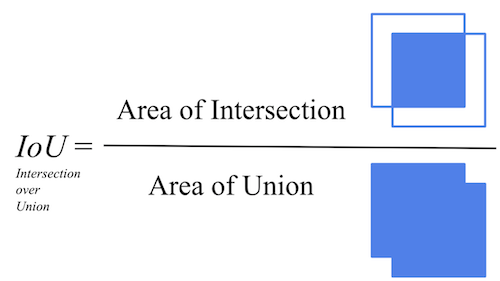

# 参考ページ
[Faster R-CNNにおけるRPNの世界一分かりやすい解説](https://medium.com/lsc-psd/faster-r-cnn%E3%81%AB%E3%81%8A%E3%81%91%E3%82%8Brpn%E3%81%AE%E4%B8%96%E7%95%8C%E4%B8%80%E5%88%86%E3%81%8B%E3%82%8A%E3%82%84%E3%81%99%E3%81%84%E8%A7%A3%E8%AA%AC-dfc0c293cb69)

---

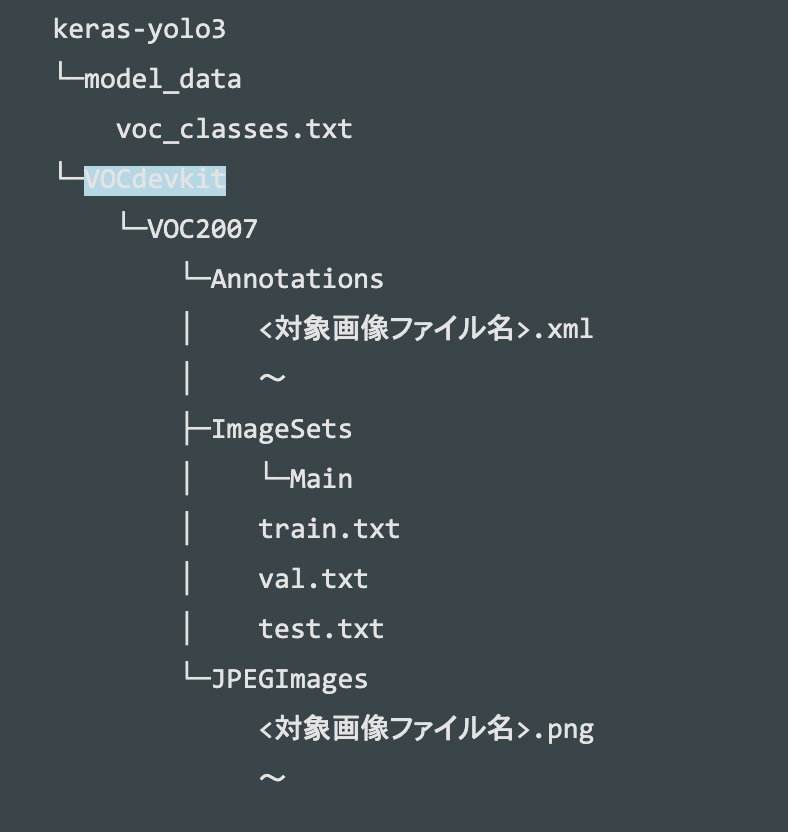